In [2]:
try:
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    cur_dir = !pwd
    if cur_dir[0] != "/content":
        print("getting back to content dir")
        %cd /content/
    else:
        print("already in /content")  
    !rm -rf 046211-project
    !git clone https://github.com/ynahum/046211-project.git
    %cd 046211-project
    !pip install learn2learn

already in /content
Cloning into '046211-project'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 119 (delta 65), reused 70 (delta 29), pack-reused 4
Receiving objects: 100% (119/119), 492.77 KiB | 3.26 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/046211-project
     |████████████████████████████████| 604 kB 4.2 MB/s 
     |████████████████████████████████| 2.9 MB 55.4 MB/s 
     |████████████████████████████████| 135 kB 70.9 MB/s 
     |████████████████████████████████| 96 kB 7.6 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
     |████████████████████████████████| 1.4 MB 55.5 MB/s 
     |████████████████████████████████| 3.6 MB 41.2 MB/s 
  Created wheel for learn2learn: filename=learn2learn-0.1.6-cp37-cp37m-linux_x86_64.whl size=945697 sha256=875d76438a700b0b03d40189f10e14b3c8899a0d69ee5b6dffefae3b13118ee7
  Stored in directory: /root/.cache/pip/whe

In [3]:
from meta_learner_module import MetaLearner
from scheduler.batch_loss_schedule import BatchLossSchedule
from scheduler.prediction_similarity_schedule import PredictionSimilaritySchedule
from scheduler.random_schedule import RandomSchedule
from config import defaults

import learn2learn as l2l
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random
import copy 

%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)

In [4]:

args = copy.deepcopy(defaults)

#play with arguments and override defaults here
args['dataset'] = "omniglot"
if args['dataset'] == "omniglot":
    args['train_sample_size'] = 15
    args['n_shots'] = 1
    args['train_adapt_steps'] = 5
    args['test_adapt_steps'] = 10
    args['per_task_lr'] = 0.1
    args['meta_lr'] = 0.003
    args['meta_batch_size'] = 8
    args['n_epochs'] = 100
    
print(args)

dataset = args['dataset']
train_sample_size = args['train_sample_size']
n_test_labels = args['n_test_labels']
n_shots = args['n_shots']
per_task_lr = args['per_task_lr']
meta_lr = args['meta_lr']
train_adapt_steps = args['train_adapt_steps']
test_adapt_steps = args['test_adapt_steps']
meta_batch_size = args['meta_batch_size']
n_epochs = args['n_epochs']


{'dataset': 'omniglot', 'train_sample_size': 15, 'n_test_labels': 5, 'n_shots': 1, 'per_task_lr': 0.1, 'meta_lr': 0.003, 'meta_batch_size': 8, 'train_adapt_steps': 5, 'test_adapt_steps': 10, 'n_epochs': 100}


In [5]:
print("get tasks")
task_sets = l2l.vision.benchmarks.get_tasksets(
    dataset,
    train_samples=train_sample_size,
    train_ways=n_test_labels,
    test_samples=2 * n_shots,
    test_ways=n_test_labels,
    root='~/data')

print("schedule training")
train_schedule = RandomSchedule(task_sets.train)
#train_schedule = PredictionSimilaritySchedule(task_sets.train, shots=n_shots, ways=n_test_labels, similar_first=True)
#train_schedule = BatchLossSchedule(task_sets.train, shots=n_shots, ways=n_test_labels, hardest_first=True)


get tasks


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting /root/data/omniglot-py/images_background.zip to /root/data/omniglot-py


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting /root/data/omniglot-py/images_evaluation.zip to /root/data/omniglot-py
schedule training


In [6]:
print(f"load model (dataset is {dataset})")
if dataset == "mini-imagenet":
    model = l2l.vision.models.MiniImagenetCNN(n_test_labels)
else:
    model = l2l.vision.models.OmniglotCNN(n_test_labels)

print(model)
model.to(device)

f_loss = nn.CrossEntropyLoss(reduction='mean')

print(f"create meta learner")
meta_learner = MetaLearner(
    per_task_lr,
    meta_lr,
    train_adapt_steps,
    test_adapt_steps,
    meta_batch_size,
    model,
    f_loss,
    device)


load model (dataset is omniglot)
OmniglotCNN(
  (base): ConvBase(
    (0): ConvBlock(
      (normalize): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): ConvBlock(
      (normalize): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (2): ConvBlock(
      (normalize): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (3): ConvBlock(
      (normalize): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (features): Sequential(
 

In [7]:
print(f"meta learner train")
train_losses, train_accs = meta_learner.meta_train(n_epochs, train_schedule)


meta learner train


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


epoch=1/100, loss=0.717, acc=0.770
epoch=2/100, loss=0.733, acc=0.757
epoch=3/100, loss=0.665, acc=0.780
epoch=4/100, loss=0.725, acc=0.760
epoch=5/100, loss=0.767, acc=0.740
epoch=6/100, loss=0.625, acc=0.794
epoch=7/100, loss=0.660, acc=0.770
epoch=8/100, loss=0.489, acc=0.851
epoch=9/100, loss=0.517, acc=0.838
epoch=10/100, loss=0.554, acc=0.828
epoch=11/100, loss=0.615, acc=0.804
epoch=12/100, loss=0.461, acc=0.848
epoch=13/100, loss=0.384, acc=0.889
epoch=14/100, loss=0.525, acc=0.821
epoch=15/100, loss=0.546, acc=0.821
epoch=16/100, loss=0.475, acc=0.838
epoch=17/100, loss=0.497, acc=0.807
epoch=18/100, loss=0.533, acc=0.841
epoch=19/100, loss=0.578, acc=0.801
epoch=20/100, loss=0.449, acc=0.868
epoch=21/100, loss=0.379, acc=0.899
epoch=22/100, loss=0.490, acc=0.858
epoch=23/100, loss=0.428, acc=0.878
epoch=24/100, loss=0.414, acc=0.861
epoch=25/100, loss=0.524, acc=0.828
epoch=26/100, loss=0.461, acc=0.861
epoch=27/100, loss=0.443, acc=0.872
epoch=28/100, loss=0.482, acc=0.855
e

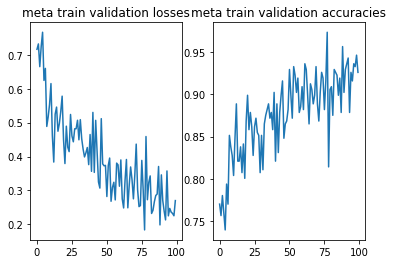

In [9]:
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("meta train validation losses") 
ax1.plot(train_losses)
ax2.set_title("meta train validation accuracies") 
ax2.plot(train_accs)

In [11]:
print(f"meta learner test")
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)

meta_test_loss, meta_test_acc = meta_learner.meta_test(task_sets.test)


meta learner test
Meta Test Error 0.36584093514829874
Meta Test Accuracy 0.9000000059604645


In [12]:
checkpoint = {'maml_hyper_params': args,
              'state_dict': model.state_dict()}
filename = f'meta_test_accuracy_{meta_test_acc:.3f}_checkpoint.pth'
torch.save(checkpoint, filename)